In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.stats import chi2_contingency

In [29]:
def chi_squre_for_missingness(df,target_var):
    results = []

    for column in df.columns:
        if column == target_var or df[column].isnull().sum() == 0:
            continue
        df['missing_{column}'.format(column=column)] = df[column].isnull().astype(int)

        contingency_table = pd.crosstab(df['missing_{column}'.format(column=column)], df[target_var], margins = False)

        try:
            chi2, p, dof, expected = chi2_contingency(contingency_table)
            
            # Interpret the results
            interpretation = "Independent (MCAR)" if p > 0.05 else "Dependent (MAR)"
            
            # Append results to the list
            results.append({
                'Column': column,
                'Chi2 Statistic': chi2,
                'P-value': p,
                'Degrees of Freedom': dof,
                'Interpretation': interpretation
            })
        except ValueError as e:
            results.append({
                'column': column,
                'Chi2 Statistic': np.nan,
                'p-value': np.nan,
                'interpretation': f"Error: {str(e)}" 
            })
        df.drop(columns=[f'missing_{column}'], inplace=True)
    results_df = pd.DataFrame(results)
    return results_df

In [2]:
def read_data(fileNames):
    curentDir = os.getcwd()
    file_path = os.path.join(curentDir, fileNames)
    data = pd.read_csv(file_path)
    return data

In [3]:
trainData = read_data('train.csv')

In [5]:
print(trainData.head(5))

   ID                       dri_score psych_disturb    cyto_score diabetes  \
0   0  N/A - non-malignant indication            No           NaN       No   
1   1                    Intermediate            No  Intermediate       No   
2   2  N/A - non-malignant indication            No           NaN       No   
3   3                            High            No  Intermediate       No   
4   4                            High            No           NaN       No   

   hla_match_c_high  hla_high_res_8          tbi_status arrhythmia  \
0               NaN             NaN              No TBI         No   
1               2.0             8.0  TBI +- Other, >cGy         No   
2               2.0             8.0              No TBI         No   
3               2.0             8.0              No TBI         No   
4               2.0             8.0              No TBI         No   

   hla_low_res_6  ...          tce_div_match donor_related  \
0            6.0  ...                    NaN    

In [6]:
print(trainData.shape)

(28800, 60)


In [7]:
print(trainData.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28800 entries, 0 to 28799
Data columns (total 60 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ID                      28800 non-null  int64  
 1   dri_score               28646 non-null  object 
 2   psych_disturb           26738 non-null  object 
 3   cyto_score              20732 non-null  object 
 4   diabetes                26681 non-null  object 
 5   hla_match_c_high        24180 non-null  float64
 6   hla_high_res_8          22971 non-null  float64
 7   tbi_status              28800 non-null  object 
 8   arrhythmia              26598 non-null  object 
 9   hla_low_res_6           25530 non-null  float64
 10  graft_type              28800 non-null  object 
 11  vent_hist               28541 non-null  object 
 12  renal_issue             26885 non-null  object 
 13  pulm_severe             26665 non-null  object 
 14  prim_disease_hct        28800 non-null

In [8]:
missing_values = trainData.isnull().sum()
missing_values = missing_values.sort_values(ascending=False)
print(missing_values)

tce_match                 18996
mrd_hct                   16597
cyto_score_detail         11923
tce_div_match             11396
tce_imm_match             11133
cyto_score                 8068
hla_high_res_10            7163
hla_high_res_8             5829
hla_high_res_6             5284
hla_match_dqb1_high        5199
hla_low_res_10             5064
conditioning_intensity     4789
hla_match_c_high           4620
hla_match_a_high           4301
hla_nmdp_6                 4197
hla_match_dqb1_low         4194
hla_match_b_high           4088
hla_low_res_8              3653
hla_match_drb1_high        3352
hla_low_res_6              3270
hla_match_c_low            2800
hla_match_drb1_low         2643
hla_match_b_low            2565
cardiac                    2542
peptic_ulcer               2419
hla_match_a_low            2390
arrhythmia                 2202
rheum_issue                2183
rituximab                  2148
pulm_severe                2135
diabetes                   2119
psych_di

In [14]:
round((trainData.isnull().sum()/len(trainData)).sort_values(ascending=False),4)

tce_match                 0.6596
mrd_hct                   0.5763
cyto_score_detail         0.4140
tce_div_match             0.3957
tce_imm_match             0.3866
cyto_score                0.2801
hla_high_res_10           0.2487
hla_high_res_8            0.2024
hla_high_res_6            0.1835
hla_match_dqb1_high       0.1805
hla_low_res_10            0.1758
conditioning_intensity    0.1663
hla_match_c_high          0.1604
hla_match_a_high          0.1493
hla_nmdp_6                0.1457
hla_match_dqb1_low        0.1456
hla_match_b_high          0.1419
hla_low_res_8             0.1268
hla_match_drb1_high       0.1164
hla_low_res_6             0.1135
hla_match_c_low           0.0972
hla_match_drb1_low        0.0918
hla_match_b_low           0.0891
cardiac                   0.0883
peptic_ulcer              0.0840
hla_match_a_low           0.0830
arrhythmia                0.0765
rheum_issue               0.0758
rituximab                 0.0746
pulm_severe               0.0741
diabetes  

# Determine if the missing values are MCAR, MAR, or MNAR

In [19]:
train_df,test_df = train_test_split(trainData, test_size=0.3, random_state=117)

In [20]:
print("The shape of the train dataset is {} rows and {} columns (70% of the data)".format(train_df.shape[0],train_df.shape[1]))
print("The shape of the test dataset is {} rows and {} columns (30% of the data)".format(test_df.shape[0],test_df.shape[1]))

The shape of the train dataset is 20160 rows and 60 columns (70% of the data)
The shape of the test dataset is 8640 rows and 60 columns (30% of the data)


In [22]:
null_values_train = train_df.isnull().mean().sort_values(ascending=False)*100
null_values_train = null_values_train[null_values_train>0]
null_values_test = test_df.isnull().mean().sort_values(ascending=False)*100
null_values_test = null_values_test[null_values_test>0]

C:\Users\tgw20\AppData\Local\Temp\ipykernel_54324\3473481664.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')  # Rotate and align x-axis labels
C:\Users\tgw20\AppData\Local\Temp\ipykernel_54324\3473481664.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')  # Rotate and align x-axis labels


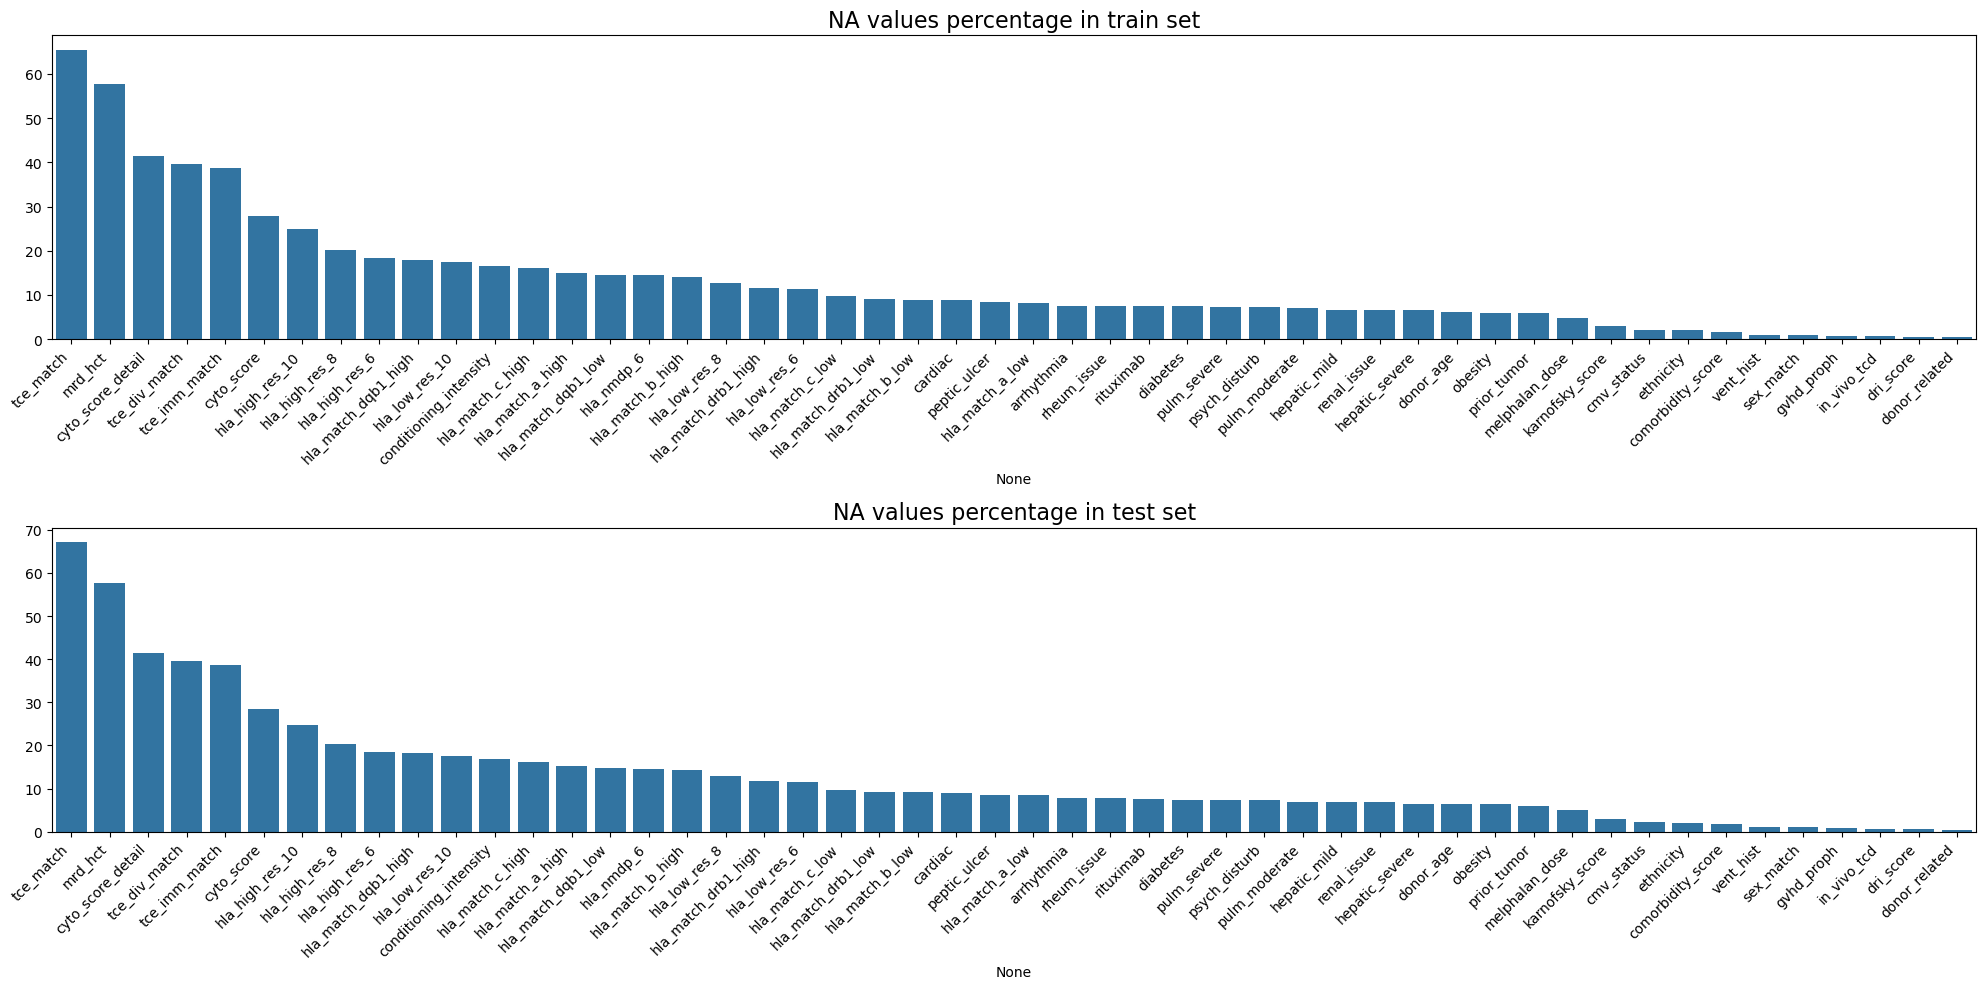

In [27]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(20,10))
sns.barplot(x=null_values_train.index, y=null_values_train.values, ax=ax[0])
ax[0].set_title('NA values percentage in train set', fontsize=16)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=45, ha='right')  # Rotate and align x-axis labels

# Second plot
sns.barplot(x=null_values_train.index, y=null_values_test.values, ax=ax[1])
ax[1].set_title('NA values percentage in test set', fontsize=16)
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=45, ha='right')  # Rotate and align x-axis labels

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()

In [32]:
results_df = chi_squre_for_missingness(train_df, 'race_group')
print(results_df)


                    Column  Chi2 Statistic        P-value  Degrees of Freedom  \
0                dri_score       11.314148   4.549509e-02                   5   
1            psych_disturb      124.875403   2.907877e-25                   5   
2               cyto_score      335.898048   1.899629e-70                   5   
3                 diabetes      128.975930   3.925334e-26                   5   
4         hla_match_c_high      294.026537   1.926509e-61                   5   
5           hla_high_res_8      348.351059   3.963766e-73                   5   
6               arrhythmia      133.472460   4.359676e-27                   5   
7            hla_low_res_6      264.139492   5.073762e-55                   5   
8                vent_hist       22.620758   3.988260e-04                   5   
9              renal_issue      142.056202   6.539366e-29                   5   
10             pulm_severe      169.546211   9.118442e-35                   5   
11          hla_high_res_6  